In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# Define paths
dataset_path = "D:/HandGenie/bigdataset2"
model_output_path = "model/handgenie_model.h5"

In [3]:
# Hyperparameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 70  # Increased from 10 to 70

# Advanced Data Generator with Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 8346 images belonging to 26 classes.
Found 2080 images belonging to 26 classes.


In [5]:
# Save class indices
os.makedirs("model", exist_ok=True)
with open("labels.txt", "w") as f:
    for label, index in train_generator.class_indices.items():
        f.write(f"{index}:{label}\n")

In [6]:
# Load InceptionV3 without top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/70


261/261 [==============================] - ETA: 0s - loss: 1.8929 - accuracy: 0.4974
Epoch 1: val_accuracy improved from -inf to 0.69519, saving model to model\handgenie_model.h5


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


261/261 [==============================] - 340s 1s/step - loss: 1.8929 - accuracy: 0.4974 - val_loss: 1.1837 - val_accuracy: 0.6952 - lr: 1.0000e-04
Epoch 2/70
261/261 [==============================] - ETA: 0s - loss: 0.8970 - accuracy: 0.7695
Epoch 2: val_accuracy improved from 0.69519 to 0.81923, saving model to model\handgenie_model.h5
261/261 [==============================] - 266s 1s/step - loss: 0.8970 - accuracy: 0.7695 - val_loss: 0.7109 - val_accuracy: 0.8192 - lr: 1.0000e-04
Epoch 3/70
261/261 [==============================] - ETA: 0s - loss: 0.6300 - accuracy: 0.8379
Epoch 3: val_accuracy improved from 0.81923 to 0.86154, saving model to model\handgenie_model.h5
261/261 [==============================] - 327s 1s/step - loss: 0.6300 - accuracy: 0.8379 - val_loss: 0.5404 - val_accuracy: 0.8615 - lr: 1.0000e-04
Epoch 4/70
261/261 [==============================] - ETA: 0s - loss: 0.4967 - accuracy: 0.8717
Epoch 4: val_accuracy improved from 0.86154 to 0.88462, saving model to

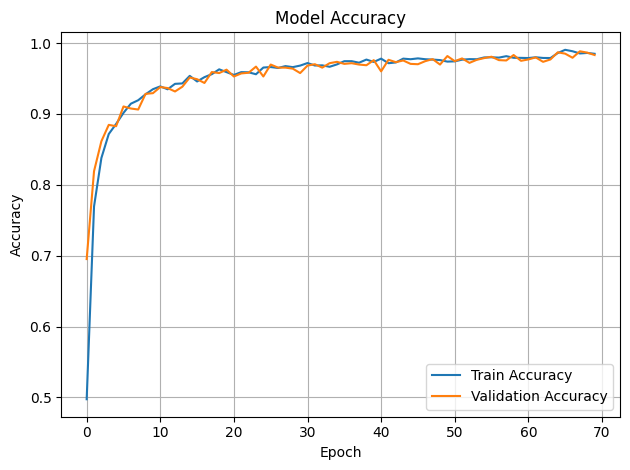

In [7]:
# Callbacks
checkpoint = ModelCheckpoint(model_output_path, monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
callbacks = [checkpoint, early_stop, reduce_lr]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Found 2080 images belonging to 26 classes.
65/65 [==============================] - 30s 438ms/step
Classification Report:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        80
           B       1.00      1.00      1.00        80
           C       1.00      1.00      1.00        80
           D       0.99      1.00      0.99        80
           E       0.99      1.00      0.99        80
           F       1.00      0.99      0.99        80
           G       1.00      1.00      1.00        80
           H       1.00      1.00      1.00        80
           I       1.00      1.00      1.00        80
           J       1.00      1.00      1.00        80
           K       1.00      1.00      1.00        80
           L       1.00      1.00      1.00        80
           M       0.99      0.99      0.99        80
           N       1.00      0.99      0.99        80
           O       1.00      1.00      1.00        80
           P

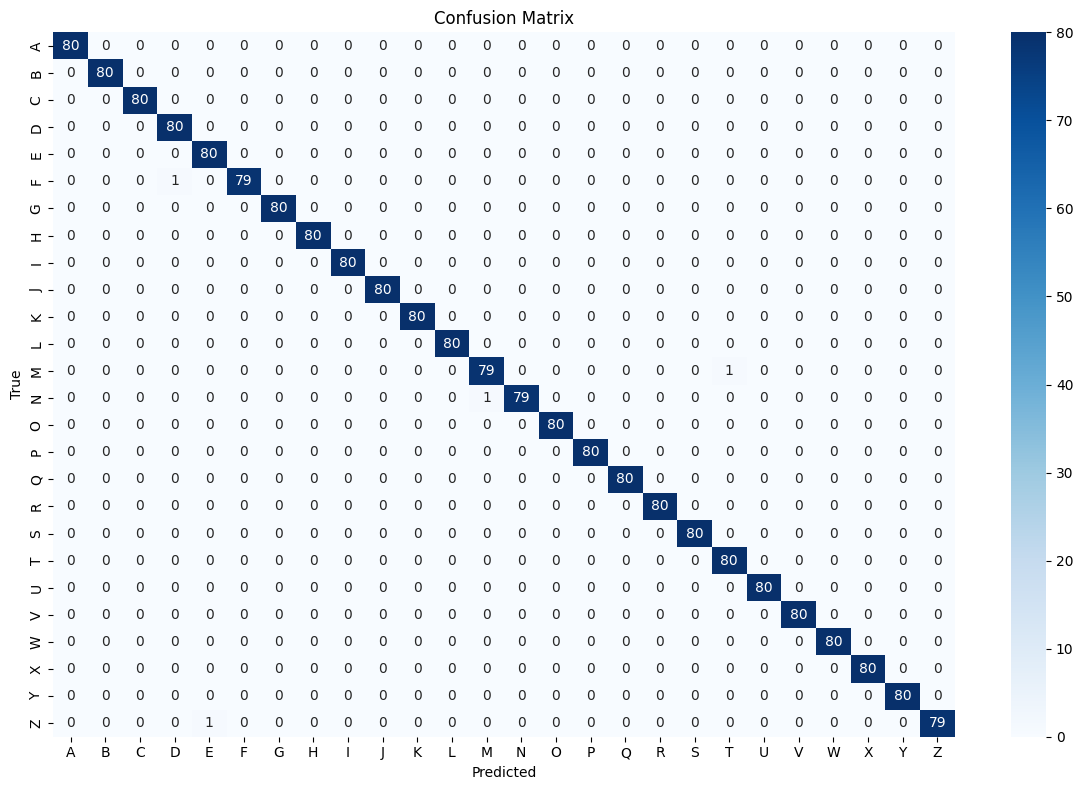

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
dataset_path = "D:/HandGenie/bigdataset2"
model_path = "model/handgenie_model.h5"

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Load model
model = load_model(model_path)

# Prepare validation data again
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Predict labels
pred_probs = model.predict(val_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


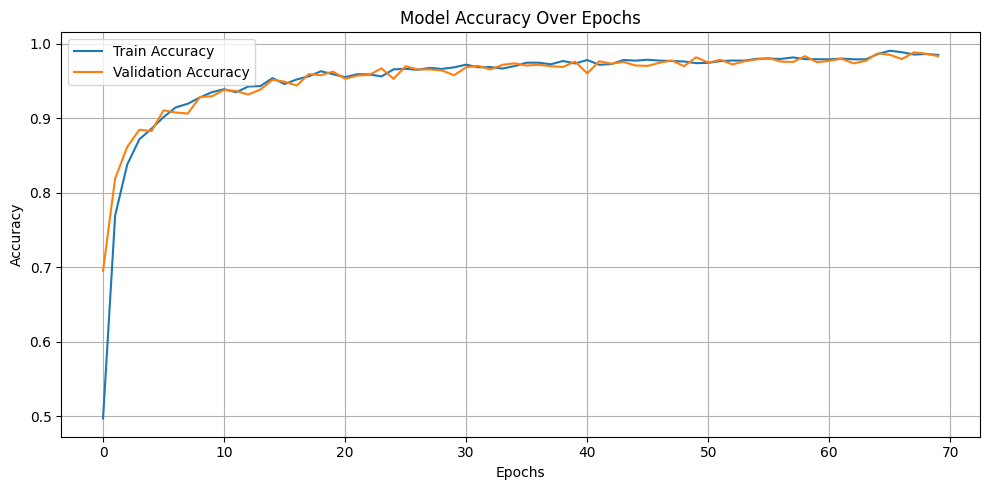

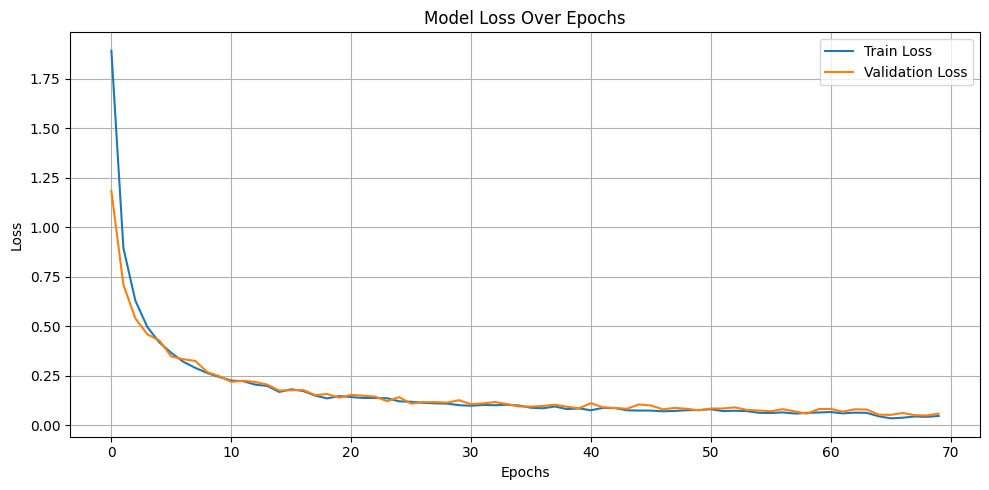

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_over_epochs.png")
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_over_epochs.png")
plt.show()


65/65 [==============================] - 28s 429ms/step


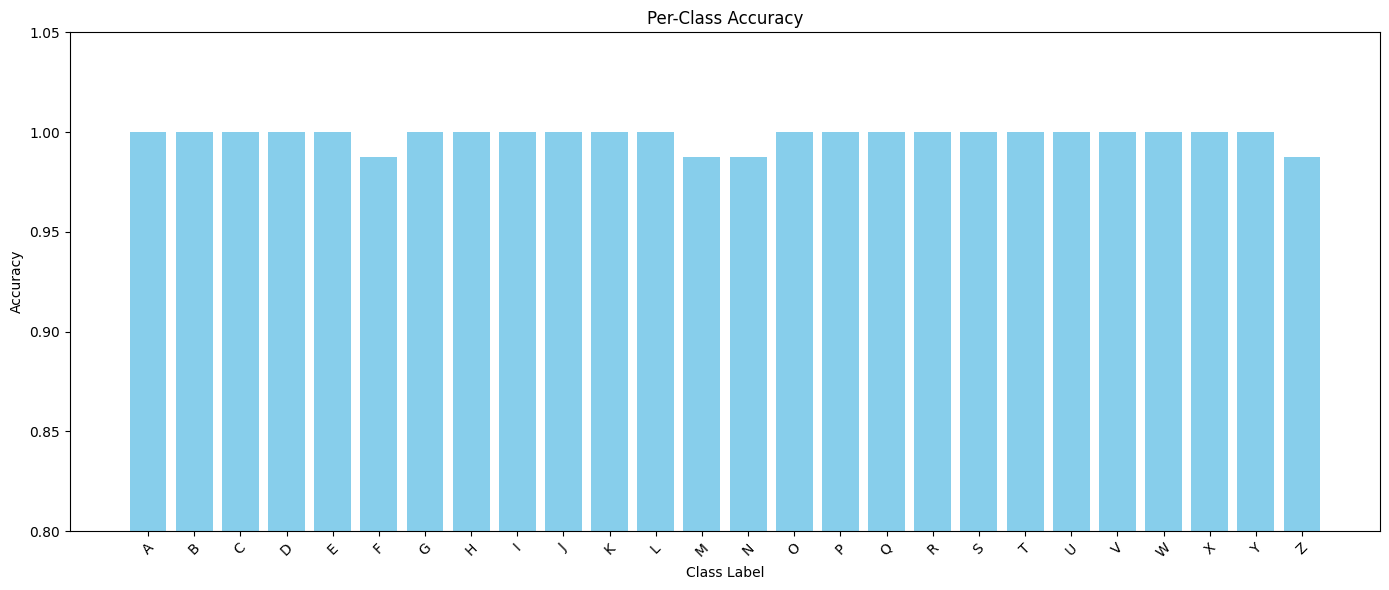

In [10]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Get ground truth labels and predictions
val_generator.reset()
Y_true = val_generator.classes
Y_pred = model.predict(val_generator, verbose=1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Get label map
labels = list(val_generator.class_indices.keys())
class_indices = val_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

# Calculate per-class accuracy
from collections import defaultdict

correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)

for true, pred in zip(Y_true, Y_pred_classes):
    if true == pred:
        correct_per_class[true] += 1
    total_per_class[true] += 1

per_class_accuracy = {
    inv_class_indices[i]: correct_per_class[i] / total_per_class[i]
    for i in total_per_class
}

# Plot per-class accuracy
plt.figure(figsize=(14, 6))
plt.bar(per_class_accuracy.keys(), per_class_accuracy.values(), color='skyblue')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.05)
plt.title('Per-Class Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Class Label')
plt.tight_layout()
plt.savefig("per_class_accuracy.png")
plt.show()
